In [1]:
#=======Import Library========
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import solve_ivp
from scipy.io import loadmat 
from itertools import product
from copy import deepcopy as cp
from sklearn.linear_model import Lasso   
from sklearn.exceptions import ConvergenceWarning
import warnings        

The monomial_exponents function generates all possible monomial exponent combinations up to a given total degree for a specified number of features (num_features). It returns the valid combinations where the sum of the exponents does not exceed the total_degree. These combinations are used to create a polynomial library for the SINDy algorithm.

In [2]:
# Helper function for monomial exponents (not provided in the original code)
def monomial_exponents(num_features, order):
    """
    Generate all possible monomial exponents up to a given order for the state variables.
    
    Parameters:
        num_features : int
            The number of features (state variables).
        order : int
            The maximum polynomial degree.
    
    Returns:
        exponents : list of tuples
            Each tuple represents a monomial (exponent combination) for the state variables.
    """

    # Generate all combinations of exponents for the monomials
    exponents = ([exp for exp in product(range(order+1), repeat=num_features)])
    return exponents

Example:
For num_features = 2 which corrosponds to 2 coordinates variables and total_degree = 3, the output will be:

In [3]:
powers=monomial_exponents(2,5)
print(powers)

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]


The Theta function constructs a candidate library matrix Θ by combining polynomial, trigonometric, and time-dependent terms from the input data (x_train and t_train). It generates monomial terms for the state variables, polynomials of time, as well as sine and cosine terms for both state variables and time, depending on the specified options (${usePolX, usePolT, useTriX, useTriT}$).

In [ ]:
# Function to generate the candidate library matrix Θ for SINDy (Sparse Identification of Nonlinear Dynamical Systems)
def Theta(x_train, t_train, order=5, usePolX=True, usePolT=False, useTriX=False, useTriT=False):
    """
    Generate the candidate library matrix (Θ) for Sparse Identification of Nonlinear Dynamical Systems (SINDy).
    
    Parameters:
        x_train : ndarray, shape (n_samples, n_features)
            The state variables (e.g., x, y, z values over time).
        t_train : ndarray, shape (n_samples,)
            The time points corresponding to the states.
        order : int
            The maximum polynomial degree for terms in x and t.
        usePolX : bool
            Whether to include polynomial terms in x (state variables).
        usePolT : bool
            Whether to include polynomial terms in t (time).
        useTriX : bool
            Whether to include sine and cosine terms for monomials in x.
        useTriT : bool
            Whether to include sine and cosine terms for polynomials in t.

    Returns:
        mat_theta : ndarray, shape (n_samples, Theta_columns)
            The candidate library matrix Θ constructed from the state variables and time.
    """
    
    # Dimensions of the input data
    num_samples, num_features = x_train.shape  # Number of samples and features
    powers = monomial_exponents(num_features, order)  # Monomial exponents for features
    
    # Initialize the total number of columns in Θ based on the flags provided
    Theta_columns = 0 
    
    # Determine the number of columns based on which terms to include
    if(usePolX): Theta_columns += len(powers)  # Polynomial terms in x
    if(usePolT): Theta_columns += order        # Time polynomial terms
    if(useTriX): Theta_columns += 2 * num_features * len(powers)  # Sin and Cos of x monomials
    if(useTriT): Theta_columns += 2 * order    # Sin and Cos of time
    
    # Initialize the Θ matrix (n_samples x Theta_columns)
    mat_theta = np.zeros((num_samples, Theta_columns))
    
    # Index for tracking columns in mat_theta
    col = 0
    
    # Logging: Start constructing Θ matrix
    #print(f"\nBuilding Θ matrix with {num_samples} samples and {Theta_columns} columns.")
    
    if (usePolX):
        # 1. Polynomial terms in x
        #print("Including polynomial terms in x...")
        for power in powers:
            # Create the polynomial term as a string for logging
            poly_term = create_polynomial_string(power)
            # Multiply the corresponding columns in x_train raised to the power
            mat_theta[:, col] = np.prod(np.power(x_train, power), axis=1)
            col += 1
            #print(f"  Polynomial term ({poly_term}): Column {col-1}")
    
    if (usePolT):
        # 2. Polynomial terms in t
        #print("Including polynomial terms in t...")
        for deg in range(1, order + 1):
            # Create the polynomial term for time as a string
            poly_term = f"t^{deg}"
            # Add polynomial terms for time t (t^1, t^2, ..., t^order)
            mat_theta[:, col] = np.power(t_train, deg)
            col += 1
            print(f"  Polynomial term ({poly_term}): Column {col-1}")
    
    if (useTriX):
        # 3. Sin and Cos of monomials in x
        #print("Including sine and cosine terms for monomials in x...")
        for feature_idx in range(num_features):
            for power in powers:
                # Apply sin and cos for each monomial term in x
                mat_theta[:, col] = np.sin(np.power(x_train[:, feature_idx], power[feature_idx]))
                col += 1
                mat_theta[:, col] = np.cos(np.power(x_train[:, feature_idx], power[feature_idx]))
                col += 1
                # Create a readable polynomial term for sin/cos
                poly_term = create_polynomial_string(power)
                #print(f"  sin/cos term for {poly_term} (feature {feature_idx}): Columns {col-2} and {col-1}")
    
    if (useTriT):
        # 4. Sin and Cos of time
        #print("Including sine and cosine terms for time...")
        for deg in range(1, order + 1):
            # Create the polynomial term for time as a string for sin/cos
            poly_term = f"t^{deg}"
            # Apply sin and cos for each polynomial term in time
            mat_theta[:, col] = np.sin(np.power(t_train, deg))
            col += 1
            mat_theta[:, col] = np.cos(np.power(t_train, deg))
            col += 1
            #print(f"  sin/cos term for {poly_term}: Columns {col-2} and {col-1}")
    
    # Logging: Finished constructing Θ matrix
    #print(f"\nFinished building Θ matrix with {col} columns.")
    mat_theta = np.nan_to_num(mat_theta, nan=0.0, posinf=1e10, neginf=-1e10)
    
    return mat_theta

def create_polynomial_string(power):
    """
    Converts a tuple of exponents to a readable polynomial string.
    
    Parameters:
        power : tuple
            A tuple of exponents, e.g., (2, 1) for x^2 * y^1.
    
    Returns:
        poly_term : str
            A string representing the polynomial, e.g., "x^2y".
    """
    poly_term = ""
    for i, p in enumerate(power):
        if p > 0:
            poly_term += f"x{i+1}^{p}" if p > 1 else f"x{i+1}"
    return poly_term if poly_term else "1"  # Return "1" for constant term


The alasso function implements Adaptive Lasso, a regularization method that applies iterative reweighting to improve the sparsity of the solution. It starts by fitting a standard Lasso model on the given candidate library matrix (RHS, representing the monomials) and the time derivatives (LHS). The coefficients obtained from Lasso are then used to update weights, and the process repeats for a set number of iterations (**max_iter**) until convergence ( **alasso_tol**). The final coefficients (**coef_**)  represent the most relevant terms of the system's dynamics.

In [56]:
# Adaptive Lasso implementation with logging
def alasso(RHS, LHS, alpha, delta=1.0, max_iter=100, lasso_tol=1e-3, alasso_tol=1e-6):
    """
    Adaptive Lasso using iterative reweighting with detailed logging.

    Parameters:
        RHS : ndarray, shape (n_samples, n_features)
            The Theta matrix (candidate functions).
        LHS : ndarray, shape (n_samples,)
            The time derivative of a single state variable.
        alpha : float
            Regularization parameter for Lasso.
        delta : float
            Power of weights in adaptive reweighting (typically 1.0).
        max_iter : int
            Number of outer iterations for adaptive updates.
        lasso_tol : float
            Tolerance for inner Lasso solver.
        alasso_tol : float
            Convergence threshold for weight change.

    Returns:
        coef_ : ndarray, shape (n_features,)
            Final sparse coefficients.
    """
    n_samples, n_features = RHS.shape
    weights = np.ones(n_features)
    
    # Printing header for log
    print(f"\n{'Iteration':<10}{'Weight Δ':<15}{'Coef Δ':<15}{'L1 Norm':<15}{'Max Coef':<15}{'Nonzero Coefs':<15}")
    print('-' * 80)

    for iter_num in range(max_iter):
        prev_weights = cp(weights)

        # Re-weight design matrix
        RHS_w = RHS / weights[np.newaxis, :]

        # Solve Lasso on weighted features
        lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=10000, tol=lasso_tol)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", ConvergenceWarning)
            lasso.fit(RHS_w, LHS)

        # Recover unweighted coefficients
        coef_ = lasso.coef_ / weights

        # Update weights
        weights = 1.0 / (np.abs(coef_) ** delta + 1e-8)  # Add epsilon to avoid division by zero

        # Calculate L1 norm of coefficients (for convergence check)
        l1_norm = np.linalg.norm(coef_, 1)
        
        # Calculate max coefficient value for logs
        max_coef = np.max(np.abs(coef_))
        
        # Calculate number of nonzero coefficients
        nonzero_coef = np.sum(coef_ != 0)

        # Log current iteration details
        weight_change = np.mean((weights - prev_weights) ** 2)
        coef_change = np.mean(np.abs(coef_ - prev_weights))

        print(f"{iter_num:<10}{weight_change:<15.3e}{coef_change:<15.3e}{l1_norm:<15.3e}{max_coef:<15.3e}{nonzero_coef:<15}")

        # Check convergence based on weight change
        if weight_change < alasso_tol:
            print(f"Converged after {iter_num} iterations")
            break

    return coef_

**Example 1: Linear ODE**

Here we define the functions of ODE.

The first example is a Linear, damped harmonic oscillator which is a linear 2D ODE:
 
$$ \begin{aligned} \dot{x} &= -0.1{x}+2{y}\\ \dot{y} &= -2{x}-0.1{y} \end{aligned}$$

In [6]:
# Linear, damped harmonic oscillator
def linear_damped_SHO(t, x):
    return [-0.1 * x[0] + 2 * x[1], -2 * x[0] - 0.1 * x[1]]

Now, we need to generate some training data of this ODE by solving it directly using scipy.solve_ivp.

In [7]:
# Generate training data
dt = 0.01
t_train = np.arange(0, 25, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [2, 0]
x_train = solve_ivp(linear_damped_SHO, t_train_span, 
                    x0_train, t_eval=t_train).y.T

In [8]:
x_train

array([[ 2.        ,  0.        ],
       [ 1.99760141, -0.03995736],
       [ 1.99440741, -0.07981887],
       ...,
       [ 0.15587048,  0.05030749],
       [ 0.15668861,  0.04713307],
       [ 0.15744235,  0.04394611]])

In [9]:
t_train

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 2.497e+01, 2.498e+01,
       2.499e+01])

The result has shape of (2500,2) which corrospnds to 2500 time measurement points and 2 features of $\dot{x}$ and $\dot{y}$. 

In [10]:
# Fit the model
matrix_theta=Theta(x_train,t_train,5,True,False,False,False)
      

In [11]:
print(matrix_theta.shape)

(2500, 36)


In [12]:
# Calculate time derivatives (dx/dt)
dxdt = np.array([np.gradient(x_train[:, i], dt) for i in range(x_train.shape[1])]).T  # shape: (samples, features)


In [13]:
# Fit Adaptive Lasso for each state variable (i.e., for each feature in x_train)
coefficients = np.zeros((matrix_theta.shape[1], x_train.shape[1]))
for i in range(x_train.shape[1]):
    print(f"\nFitting variable {i}:")
    coefficients[:, i] = alasso(matrix_theta, dxdt[:, i], alpha=0.000001)


Fitting variable 0:

Iteration Weight Δ       Coef Δ         L1 Norm        Max Coef       Nonzero Coefs  
--------------------------------------------------------------------------------
0         2.778e+14      1.003e+00      2.139e+00      2.000e+00      35             
1         9.165e+15      2.785e+06      2.101e+00      2.000e+00      2              
2         8.667e-12      9.444e+07      2.101e+00      2.000e+00      2              
Converged after 2 iterations

Fitting variable 1:

Iteration Weight Δ       Coef Δ         L1 Norm        Max Coef       Nonzero Coefs  
--------------------------------------------------------------------------------
0         8.333e+14      1.058e+00      2.123e+00      2.000e+00      33             
1         8.608e+15      8.350e+06      2.101e+00      2.000e+00      2              
2         4.962e-13      9.444e+07      2.101e+00      2.000e+00      2              
Converged after 2 iterations


In [14]:
print(monomial_exponents(x_train.shape[1],5))

coefficients

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]


array([[ 0.        ,  0.        ],
       [ 2.00033968, -0.10015674],
       [ 0.        , -0.        ],
       [-0.        ,  0.        ],
       [ 0.        , -0.        ],
       [-0.        ,  0.        ],
       [-0.10016833, -2.00038927],
       [-0.        ,  0.        ],
       [ 0.        , -0.        ],
       [-0.        , -0.        ],
       [-0.        , -0.        ],
       [-0.        , -0.        ],
       [-0.        ,  0.        ],
       [-0.        , -0.        ],
       [ 0.        ,  0.        ],
       [-0.        , -0.        ],
       [ 0.        ,  0.        ],
       [-0.        , -0.        ],
       [-0.        ,  0.        ],
       [-0.        ,  0.        ],
       [ 0.        , -0.        ],
       [-0.        ,  0.        ],
       [ 0.        , -0.        ],
       [-0.        ,  0.        ],
       [-0.        ,  0.        ],
       [-0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.        , -0.        ],
       [ 0.        ,

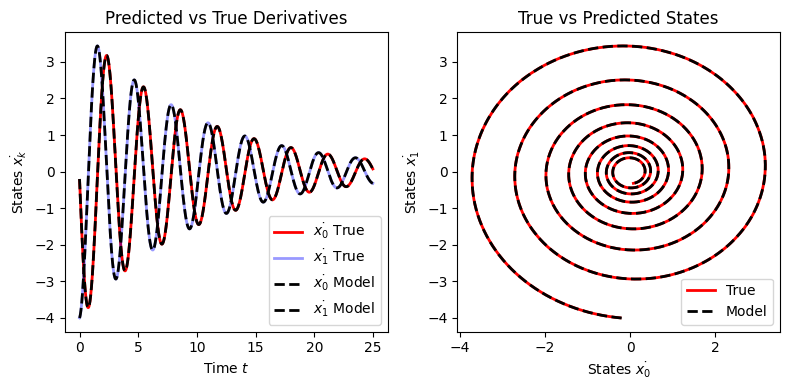

In [15]:
# Actual solution from the original system (x_train)
# Compute Theta_x for all time steps at once (this is the monomial terms for each state)
Theta_x_all = np.array([np.prod(np.power(x_train, power), axis=1) for power in powers]).T  # Shape: (num_samples, num_monomial_terms)

# Predicted derivatives using ve|ctorized matrix multiplication (Theta_x * zeta)
x_sim = np.dot(Theta_x_all, coefficients)  # Shape: (num_samples, num_state_variables)

# Create a figure with 1 row and 2 columns (for side-by-side plots)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))  # 1 row, 2 columns

# First plot: Predicted vs True Derivatives
ax[0].plot(t_train, dxdt[:, 0], "r", label=r"$\dot{x_0}$ True ", linewidth=2)
ax[0].plot(t_train, dxdt[:, 1], "b", label=r"$\dot{x_1}$ True ", alpha=0.4, linewidth=2)
ax[0].plot(t_train, x_sim[:, 0], "k--", label=r"$\dot{x_0}$ Model", linewidth=2)
ax[0].plot(t_train, x_sim[:, 1], "k--", label=r"$\dot{x_1}$ Model", linewidth=2)
ax[0].set_xlabel("Time $t$")
ax[0].set_ylabel(r"States $\dot{x_k}$")
ax[0].legend()
ax[0].set_title("Predicted vs True Derivatives")

# Second plot: True vs Predicted States
ax[1].plot(dxdt[:, 0], dxdt[:, 1], "r", label="True", linewidth=2)
ax[1].plot(x_sim[:, 0], x_sim[:, 1], "k--", label="Model", linewidth=2)
ax[1].set_xlabel(r"States $\dot{x_0}$")
ax[1].set_ylabel(r"States $\dot{x_1}$")
ax[1].legend()
ax[1].set_title("True vs Predicted States")
# Adjust layout for better spacing
plt.tight_layout()
# Show the plots
plt.show()


In [16]:
# Compute the error
error_x0 = np.linalg.norm(x_sim[:, 0] - dxdt[:, 0])
error_x1 = np.linalg.norm(x_sim[:, 1] - dxdt[:, 1])
print(f"Error for x0: {error_x0}")
print(f"Error for x1: {error_x1}")

Error for x0: 0.0715342269155084
Error for x1: 0.06359263278192612


**Example 2: Cubic ODE**

The second example is a nonlinear two-dimensional damped harmonic oscillator. This example involves cubic dynamics. The governing system used to generate training data is as follows. It is identical to the previous example except the linear terms in the right-hand side have been replaced with cubic ones.

$$ \begin{aligned} \dot{x} &= -0.1{x}^3 + 2{y}^3 \\ \dot{y} &= -2{x}^3 -0.1{y}^3 \end{aligned} $$

In [17]:
# Cubic, damped harmonic oscillator
def cubic_damped_SHO(t, x):
    return [
        -0.1 * x[0] ** 3 + 2 * x[1] ** 3,
        -2 * x[0] ** 3 - 0.1 * x[1] ** 3,
    ]

In [18]:
# Generate training data

dt = 0.01
t_train = np.arange(0, 25, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [2, 0]
x_train = solve_ivp(cubic_damped_SHO, t_train_span, 
                    x0_train, t_eval=t_train).y.T

In [19]:
# Fit the model
matrix_theta=Theta(x_train,t_train,5,True,False,False,False)

# Calculate time derivatives (dx/dt)
dxdt = np.array([np.gradient(x_train[:, i], dt) for i in range(x_train.shape[1])]).T  # shape: (samples, features)

# Fit Adaptive Lasso for each state variable (i.e., for each feature in x_train)
coefficients = np.zeros((matrix_theta.shape[1], x_train.shape[1]))
for i in range(x_train.shape[1]):
    print(f"\nFitting variable {i}:")
    coefficients[:, i] = alasso(matrix_theta, dxdt[:, i], alpha=0.00005)


Fitting variable 0:

Iteration Weight Δ       Coef Δ         L1 Norm        Max Coef       Nonzero Coefs  
--------------------------------------------------------------------------------
0         1.944e+15      1.002e+00      2.260e+00      1.995e+00      29             
1         6.942e+15      1.945e+07      2.101e+00      1.996e+00      4              
2         5.555e+14      8.889e+07      2.093e+00      1.994e+00      2              
3         1.504e-07      9.444e+07      2.093e+00      1.994e+00      2              
4         5.786e-12      9.444e+07      2.093e+00      1.994e+00      2              
Converged after 4 iterations

Fitting variable 1:

Iteration Weight Δ       Coef Δ         L1 Norm        Max Coef       Nonzero Coefs  
--------------------------------------------------------------------------------
0         1.944e+15      1.058e+00      2.221e+00      1.999e+00      29             
1         6.944e+15      1.945e+07      2.100e+00      1.996e+00      4      

In [20]:
powers=monomial_exponents(x_train.shape[1],5)
print(powers)

coefficients

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]


array([[ 0.        , -0.        ],
       [-0.        ,  0.        ],
       [ 0.        , -0.        ],
       [ 1.99434991, -0.09842406],
       [ 0.        , -0.        ],
       [ 0.        , -0.        ],
       [ 0.        ,  0.        ],
       [-0.        , -0.        ],
       [ 0.        ,  0.        ],
       [-0.        , -0.        ],
       [ 0.        ,  0.        ],
       [-0.        , -0.        ],
       [ 0.        , -0.        ],
       [-0.        ,  0.        ],
       [ 0.        , -0.        ],
       [-0.        ,  0.        ],
       [ 0.        , -0.        ],
       [-0.        ,  0.        ],
       [-0.09902819, -1.99521241],
       [-0.        , -0.        ],
       [ 0.        ,  0.        ],
       [-0.        , -0.        ],
       [ 0.        ,  0.        ],
       [-0.        , -0.        ],
       [ 0.        , -0.        ],
       [-0.        ,  0.        ],
       [ 0.        , -0.        ],
       [-0.        ,  0.        ],
       [ 0.        ,

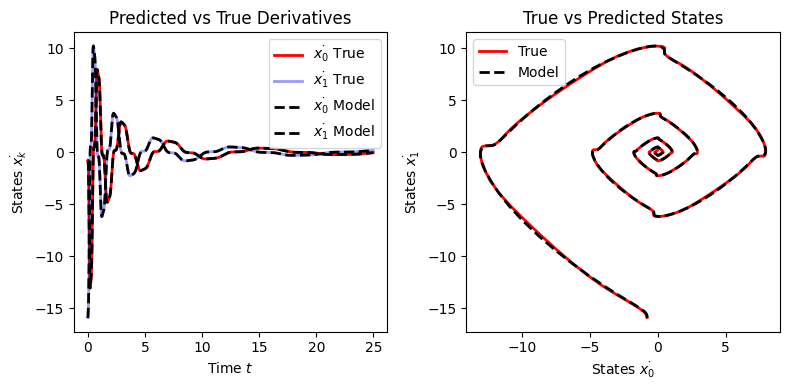

In [21]:
# Actual solution from the original system (x_train)
# Compute Theta_x for all time steps at once (this is the monomial terms for each state)
Theta_x_all = np.array([np.prod(np.power(x_train, power), axis=1) for power in powers]).T  # Shape: (num_samples, num_monomial_terms)

# Predicted derivatives using ve|ctorized matrix multiplication (Theta_x * zeta)
x_sim = np.dot(Theta_x_all, coefficients)  # Shape: (num_samples, num_state_variables)

# Create a figure with 1 row and 2 columns (for side-by-side plots)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))  # 1 row, 2 columns

# First plot: Predicted vs True Derivatives
ax[0].plot(t_train, dxdt[:, 0], "r", label=r"$\dot{x_0}$ True ", linewidth=2)
ax[0].plot(t_train, dxdt[:, 1], "b", label=r"$\dot{x_1}$ True ", alpha=0.4, linewidth=2)
ax[0].plot(t_train, x_sim[:, 0], "k--", label=r"$\dot{x_0}$ Model", linewidth=2)
ax[0].plot(t_train, x_sim[:, 1], "k--", label=r"$\dot{x_1}$ Model", linewidth=2)
ax[0].set_xlabel("Time $t$")
ax[0].set_ylabel(r"States $\dot{x_k}$")
ax[0].legend()
ax[0].set_title("Predicted vs True Derivatives")

# Second plot: True vs Predicted States
ax[1].plot(dxdt[:, 0], dxdt[:, 1], "r", label="True", linewidth=2)
ax[1].plot(x_sim[:, 0], x_sim[:, 1], "k--", label="Model", linewidth=2)
ax[1].set_xlabel(r"States $\dot{x_0}$")
ax[1].set_ylabel(r"States $\dot{x_1}$")
ax[1].legend()
ax[1].set_title("True vs Predicted States")
# Adjust layout for better spacing
plt.tight_layout()
# Show the plots
plt.show()


In [22]:
# Compute the error
error_x0 = np.linalg.norm(x_sim[:, 0] - dxdt[:, 0])
error_x1 = np.linalg.norm(x_sim[:, 1] - dxdt[:, 1])
print(f"Error for x0: {error_x0}")
print(f"Error for x1: {error_x1}")

Error for x0: 0.7567602612579061
Error for x1: 0.6680827880857408


**Example 3: Linear 3D ODE**

Our final example of this section shows the application of SINDy to identify of a linear system in three dimensions. The governing equations are given by the following system.

$$ \begin{aligned} \dot{x} &= -0.1{x} -2{y} \\ \dot{y} &= 2{x} -0.1{y} \\ \dot{z} &= -0.3{z} \end{aligned}$$


In [23]:
# Linear 3D toy system
def linear_3D(t, x):
    return [-0.1 * x[0] - 2 * x[1], 2 * x[0] - 0.1 * x[1], -0.3 * x[2]]

In [24]:
# Generate training data

dt = .01
t_train = np.arange(0, 50, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [2, 0, 1]
x_train = solve_ivp(linear_3D, t_train_span, 
                    x0_train, t_eval=t_train).y.T

In [25]:
# Fit the model
matrix_theta=Theta(x_train,t_train,5,True,False,False,False)

# Calculate time derivatives (dx/dt)
dxdt = np.array([np.gradient(x_train[:, i], dt) for i in range(x_train.shape[1])]).T  # shape: (samples, features)

# Fit Adaptive Lasso for each state variable (i.e., for each feature in x_train)
coefficients = np.zeros((matrix_theta.shape[1], x_train.shape[1]))
for i in range(x_train.shape[1]):
    print(f"\nFitting variable {i}:")
    coefficients[:, i] = alasso(matrix_theta, dxdt[:, i], alpha=0.000001)


Fitting variable 0:

Iteration Weight Δ       Coef Δ         L1 Norm        Max Coef       Nonzero Coefs  
--------------------------------------------------------------------------------
0         5.741e+15      1.012e+00      5.212e+00      2.001e+00      92             
1         3.981e+15      5.741e+07      2.102e+00      2.001e+00      6              
2         1.852e+14      9.722e+07      2.101e+00      2.000e+00      2              
3         3.483e-15      9.907e+07      2.101e+00      2.000e+00      2              
Converged after 3 iterations

Fitting variable 1:

Iteration Weight Δ       Coef Δ         L1 Norm        Max Coef       Nonzero Coefs  
--------------------------------------------------------------------------------
0         5.556e+15      9.978e-01      3.425e+00      2.001e+00      96             
1         4.304e+15      5.556e+07      2.101e+00      2.001e+00      3              
2         4.629e+13      9.861e+07      2.101e+00      2.001e+00      2      

In [26]:
powers=monomial_exponents(x_train.shape[1],5)
print(powers)

coefficients

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (0, 3, 4), (0, 3, 5), (0, 4, 0), (0, 4, 1), (0, 4, 2), (0, 4, 3), (0, 4, 4), (0, 4, 5), (0, 5, 0), (0, 5, 1), (0, 5, 2), (0, 5, 3), (0, 5, 4), (0, 5, 5), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 0, 4), (1, 0, 5), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (1, 1, 5), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 3, 0), (1, 3, 1), (1, 3, 2), (1, 3, 3), (1, 3, 4), (1, 3, 5), (1, 4, 0), (1, 4, 1), (1, 4, 2), (1, 4, 3), (1, 4, 4), (1, 4, 5), (1, 5, 0), (1, 5, 1), (1, 5, 2), (1, 5, 3), (1, 5, 4), (1, 5, 5), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 0, 4), (2, 0, 5), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 1, 4), (2, 1, 5), (2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 2, 4), (2, 2, 5), (2, 3, 0)

array([[ 0.        , -0.        , -0.        ],
       [ 0.        , -0.        , -0.29989802],
       [ 0.        , -0.        , -0.        ],
       [ 0.        , -0.        , -0.        ],
       [ 0.        , -0.        , -0.        ],
       [-0.        , -0.        , -0.        ],
       [-2.00046785, -0.10013356, -0.        ],
       [ 0.        , -0.        , -0.        ],
       [ 0.        ,  0.        , -0.        ],
       [ 0.        ,  0.        , -0.        ],
       [ 0.        ,  0.        , -0.        ],
       [ 0.        ,  0.        , -0.        ],
       [ 0.        , -0.        , -0.        ],
       [ 0.        ,  0.        , -0.        ],
       [ 0.        ,  0.        , -0.        ],
       [ 0.        ,  0.        , -0.        ],
       [ 0.        ,  0.        , -0.        ],
       [ 0.        ,  0.        , -0.        ],
       [ 0.        ,  0.        , -0.        ],
       [ 0.        ,  0.        , -0.        ],
       [ 0.        ,  0.        , -0.   

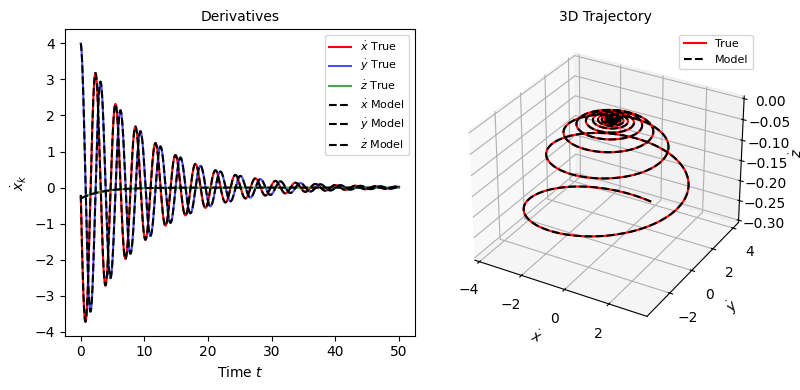

In [27]:
# Compute Theta_x for all time steps at once (this is the monomial terms for each state)
Theta_x_all = np.array([np.prod(np.power(x_train, power), axis=1) for power in powers]).T  # Shape: (num_samples, num_monomial_terms)

# Predicted derivatives using ve|ctorized matrix multiplication (Theta_x * zeta)
x_sim = np.dot(Theta_x_all, coefficients)  # Shape: (num_samples, num_state_variables)

# Create a compact figure: wide but not tall
fig = plt.figure(figsize=(8, 4))  # Width = 10, Height = 4
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# --- First plot: Time series comparison ---
ax0 = fig.add_subplot(gs[0])

# True derivatives (colored solid)
ax0.plot(t_train, dxdt[:, 0], "r", label=r"$\dot{x}$ True", linewidth=1.5)
ax0.plot(t_train, dxdt[:, 1], "b", label=r"$\dot{y}$ True", linewidth=1.5, alpha=0.7)
ax0.plot(t_train, dxdt[:, 2], "g", label=r"$\dot{z}$ True", linewidth=1.5, alpha=0.7)

# Model predictions (black dashed)
ax0.plot(t_train, x_sim[:, 0], "k--", label=r"$\dot{x}$ Model", linewidth=1.5)
ax0.plot(t_train, x_sim[:, 1], "k--", label=r"$\dot{y}$ Model", linewidth=1.5)
ax0.plot(t_train, x_sim[:, 2], "k--", label=r"$\dot{z}$ Model", linewidth=1.5)

ax0.set_xlabel("Time $t$")
ax0.set_ylabel(r"$\dot{x}_k$")
ax0.set_title("Derivatives", fontsize=10)
ax0.legend(fontsize=8)

# --- Second plot: 3D trajectory ---
ax1 = fig.add_subplot(gs[1], projection="3d")
ax1.plot(dxdt[:, 0], dxdt[:, 1], dxdt[:, 2], "r", label="True", linewidth=1.5)
ax1.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "k--", label="Model", linewidth=1.5)

ax1.set_xlabel(r"$\dot{x}$")
ax1.set_ylabel(r"$\dot{y}$")
ax1.set_zlabel(r"$\dot{z}$")
ax1.set_title("3D Trajectory", fontsize=10)
ax1.legend(fontsize=8)

# Improve layout
plt.tight_layout()
plt.show()

**Example 3: Linear 3D ODE**

Our final example of this section shows the application of SINDy to identify of a non-linear system in three dimensions. The governing equations are given by the following system.

$$ \begin{aligned} \dot{x} &= \sigma({y}-{x}) \\ \dot{y} &= {x}(\rho-{z}) -{y} \\ \dot{z} &= {x}{y} - \beta{z} \end{aligned}$$

in which $\sigma=10$, $\rho=28$ and $\beta=8/3$.

In [28]:
# Lorenz model
def lorenz(t, x, sigma=10, beta=2.66667, rho=28):
    return [
        sigma * (x[1] - x[0]),
        x[0] * (rho - x[2]) - x[1],
        x[0] * x[1] - beta * x[2],
    ]

In [29]:
# Generate training data

dt = 0.001
t_train = np.arange(0, 100, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = [-8, 8, 27]
x_train = solve_ivp(lorenz, t_train_span, 
                    x0_train, t_eval=t_train).y.T
x_dot_train_measured = np.array(
    [lorenz(0, x_train[i]) for i in range(t_train.size)]
)

In [30]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.layers import Input, Dense, BatchNormalization, Activation, Dropout, TFSMLayer
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.regularizers import l2, l1
from sklearn.decomposition import PCA
from keras.optimizers import AdamW, Adam, SGD, Lion
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.models import Model
import copy, h5py
from copy import deepcopy as cp
import pandas as pd
import os


In [31]:
def build_autoencoder(input_dim, layer_dim, activation='relu', optimizer='adam', loss='mse',
                      l2_weight=0, dropout_rate=0, use_batchnorm=False):
    """
    Builds an improved symmetrical autoencoder with optional BatchNorm, L2, Dropout.

    Parameters:
        input_dim (int): Input features
        layer_dim (list): Encoder layer sizes
        activation (str): Activation function
        optimizer (str or Optimizer): Optimizer
        loss (str): Loss function
        l2_weight (float): L2 regularization strength
        dropout_rate (float): Dropout rate (0.0 to disable)
        use_batchnorm (bool): Whether to use BatchNormalization

    Returns:
        autoencoder (Model): Compiled SAE
    """

    input_layer = Input(shape=(input_dim,))
    x = input_layer

    # Encoder
    for i, dim in enumerate(layer_dim):
        x = Dense(dim,
                  activation=activation,
                  kernel_regularizer=regularizers.l2(l2_weight),
                  name=f"encoder_dense_{i+1}")(x)
        if use_batchnorm:
            x = BatchNormalization(name=f"encoder_bn_{i+1}")(x)
        if dropout_rate > 0.0:
            x = Dropout(dropout_rate, name=f"encoder_dropout_{i+1}")(x)

    # Latent layer is x now

    # Decoder
    for i, dim in enumerate(reversed(layer_dim[:-1])):  # Skip last layer for symmetry
        x = Dense(dim,
                  activation=activation,
                  kernel_regularizer=regularizers.l2(l2_weight),
                  name=f"decoder_dense_{i+1}")(x)
        if use_batchnorm:
            x = BatchNormalization(name=f"decoder_bn_{i+1}")(x)
        if dropout_rate > 0.0:
            x = Dropout(dropout_rate, name=f"decoder_dropout_{i+1}")(x)

    # Output layer
    decoded = Dense(input_dim, name="output_dense")(x)

    # Build model
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    optimizer1=AdamW(learning_rate=1e-2, weight_decay=1e-6)
    autoencoder.compile(optimizer=optimizer, loss=loss, metrics=['mse'])

    autoencoder.summary()
    return autoencoder

def train_network(autoencoder, filename, X0, X1, monitor='val_loss',
                  n_epoch=200, patience=50, test_size=0.3,
                  random_state=1, batch=10):
    """
    Trains a stacked autoencoder with callbacks for early stopping and model checkpoint.

    Parameters:
        autoencoder (Model): Compiled Keras model
        filename (str): Base name for saving model and logs (without extension)
        X0, X1 (array-like): Input and target (usually same for autoencoders)
        monitor (str): Metric to monitor for early stopping & checkpoint
        n_epoch (int): Max number of epochs
        patience (int): Early stopping patience
        test_size (float): Fraction for validation split
        random_state (int): For reproducibility
        batch (int): Batch size
    """

    # 1️⃣ Create save directory
    save_dir = './models'
    os.makedirs(save_dir, exist_ok=True)

    # 2️⃣ Define model filename inside directory
    model_filepath = os.path.join(save_dir, filename + '.keras')  # Full model
    csv_log_filepath = os.path.join(save_dir, filename + '.csv')  # Training log CSV

    # 3️⃣ Define callbacks
    model_cb = ModelCheckpoint(model_filepath,
                               monitor=monitor,
                               save_best_only=True,
                               save_weights_only=False,  # <== FULL MODEL (.keras), no .h5!
                               verbose=1)

    early_cb = EarlyStopping(monitor=monitor,
                             patience=patience,
                             verbose=1,
                             restore_best_weights=True)  # Optional: restore best weights

    csv_logger_cb = CSVLogger(csv_log_filepath, append=False)  # Training history

    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1)


    callbacks_list = [
                    lr_scheduler,
                     model_cb, early_cb, csv_logger_cb]

    # 4️⃣ Split data
    X_train, X_test, y_train, y_test = train_test_split(X0, X1,
                                                        test_size=test_size,
                                                        random_state=random_state)

    # 5️⃣ Fit the model
    history = autoencoder.fit(X_train, y_train,
                              epochs=n_epoch,
                              batch_size=batch,
                              shuffle=True,
                              validation_data=(X_test, y_test),
                              callbacks=callbacks_list)

    # 6️⃣ Save training history again (redundant but useful)
    df_results = pd.DataFrame(history.history)
    df_results['epoch'] = history.epoch
    df_results.to_csv(csv_log_filepath, index=False)

    print(f"\n✅ Training complete. Model saved to: {model_filepath}")
    print(f"✅ Training log saved to: {csv_log_filepath}")

    return history



def load_autoencoder(model_name, layer_dim):
    # Load model
    autoencoder = load_model(model_name)
    autoencoder.summary()

    # -------------------------
    # Find the bottleneck layer
    # -------------------------
    min_dim = None
    bottleneck_layer = None
    encoder_layers = []

    for layer in autoencoder.layers:
        if isinstance(layer, Dense):
            units = layer.output.shape[1]  # ✅ FIXED here
            print(f"Layer {layer.name} → units: {units}")
            encoder_layers.append(layer)

            if (min_dim is None) or (units < min_dim):
                min_dim = units
                bottleneck_layer = layer

    print(f"\n✅ Bottleneck layer: {bottleneck_layer.name} with dimension {min_dim}\n")

    # -------------------------
    # Build encoder
    # -------------------------
    encoder_input = autoencoder.input
    encoder_output = bottleneck_layer.output

    encoder = Model(inputs=encoder_input, outputs=encoder_output)
    print("✅ Encoder built")

    # -------------------------
    # Build decoder
    # -------------------------
    latent_dim = min_dim
    decoder_input = Input(shape=(latent_dim,), name='decoder_input')

    # Find index of bottleneck layer
    bottleneck_idx = autoencoder.layers.index(bottleneck_layer)

    # The first decoder layer is after bottleneck
    first_decoder_layer = autoencoder.layers[bottleneck_idx + 1]
    x = first_decoder_layer(decoder_input)

    # Continue applying remaining layers
    for layer in autoencoder.layers[bottleneck_idx + 2:]:
        x = layer(x)

    decoder = Model(inputs=decoder_input, outputs=x)
    print("✅ Decoder built")

    return autoencoder, encoder, decoder

In [37]:
n='10'
Un = np.load("data3/Un.npy")[-2000:,:,:].reshape(2000,-1) 
Vn = np.load("data3/Vn.npy")[-2000:,:,:].reshape(2000,-1) 
#np.load("data3/Un.npy")[-2000:,:]

In [38]:
n_ts, N, k = 2000, 8192*2, 2
X = np.zeros((n_ts,N))
X[:,:] = np.hstack([Un,Vn])#Un[:,:]
X_avg = np.mean(X,axis=0)
Xrall = np.zeros((n_ts,N))
for i in range(0,n_ts):
  Xrall[i,:] = X[i,:]-X_avg
Xrall_sae = cp(Xrall)
X0_sae = cp(Xrall_sae)
min = np.min(X0_sae,axis=0)
max = np.max(X0_sae,axis=0)
X0_sae = X0_sae-min
X0_sae=X0_sae.reshape((X0_sae.shape[0],-1))
print(np.max(X0_sae))
print(np.min(X0_sae))
print(X0_sae.shape)
X0_sae3=cp(X0_sae)
X0_sae3=cp(X0_sae)

2.7363488850142863
0.0
(2000, 16384)


In [39]:
input_dim = X0_sae.shape[1]
layer_dim = [64*16,16*8,10*4,15,2] # You can tweak this based on complexity

sae = build_autoencoder(input_dim=input_dim,layer_dim=layer_dim,activation='relu',optimizer='adam',loss='mse',
                        l2_weight=0, dropout_rate=0, use_batchnorm=False)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_1 (Dense)         │ (None, 1024)           │    16,778,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_2 (Dense)         │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_3 (Dense)         │ (None, 40)             │         5,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_4 (Dense)         │ (None, 15)             │           615 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_5 (Dense)         │ (None, 2)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_1 (Dense)         │ (None, 15)             │            45 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_2 (Dense)         │ (None, 40)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_3 (Dense)         │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_4 (Dense)         │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 16384)          │    16,793,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,846,876 (129.12 MB)

 Trainable params: 33,846,876 (129.12 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
n='18'
filename = 'relu_u_sae_model_paper'+n
#train_network(sae,filename=filename,X0=X0_sae,X1=X0_sae,monitor='val_loss',n_epoch=5000,
#patience=50,test_size=0.3,random_state=1, batch=64)

In [41]:
autoencoder_sae, encoder_sae, decoder_sae= load_autoencoder('./models/'+filename+'.keras', layer_dim)

r = encoder_sae.predict(X0_sae,verbose=1)
decoded_data = decoder_sae.predict(r)
print(decoded_data.shape)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_1 (Dense)         │ (None, 1024)           │    16,778,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_2 (Dense)         │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_3 (Dense)         │ (None, 40)             │         5,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_4 (Dense)         │ (None, 15)             │           615 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dense_5 (Dense)         │ (None, 2)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_1 (Dense)         │ (None, 15)             │            45 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_2 (Dense)         │ (None, 40)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_3 (Dense)         │ (None, 128)            │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dense_4 (Dense)         │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 16384)          │    16,793,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,540,630 (387.35 MB)

 Trainable params: 33,846,876 (129.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 67,693,754 (258.23 MB)

Layer encoder_dense_1 → units: 1024
Layer encoder_dense_2 → units: 128
Layer encoder_dense_3 → units: 40
Layer encoder_dense_4 → units: 15
Layer encoder_dense_5 → units: 2
Layer decoder_dense_1 → units: 15
Layer decoder_dense_2 → units: 40
Layer decoder_dense_3 → units: 128
Layer decoder_dense_4 → units: 1024
Layer output_dense → units: 16384

✅ Bottleneck layer: encoder_dense_5 with dimension 2

✅ Encoder built
✅ Decoder built
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
(2000, 16384)


In [42]:
print(np.linalg.norm(decoded_data-X0_sae))
print(np.linalg.norm(X0_sae))
ratio = 1-np.linalg.norm(decoded_data-X0_sae)/np.linalg.norm(X0_sae)
print(ratio)

19.106414685689092
3384.82190787978
0.9943552673654086


In [43]:
reconstruct = np.zeros_like(decoded_data)
reconstruct = decoded_data +min
ratio = 1-np.linalg.norm(reconstruct-Xrall_sae)/np.linalg.norm(Xrall_sae)
print(ratio)


0.9903644350364765


In [44]:
reconstruct = np.zeros_like(decoded_data)
reconstruct = decoded_data + min+X_avg
ratio = 1-np.linalg.norm(reconstruct-X)/np.linalg.norm(X)
print(ratio)

0.9955742786387978


In [45]:
save_dir = './modelres'
os.makedirs(save_dir, exist_ok=True)  # Create it if not exists
np.save('./modelres/u_sae_enc_paper'+n+'.npy',r)  

**PCA IMPLEMENTATION**

In [46]:
x_train = np.load('modelres/u_sae_enc_paper'+n+'.npy')
x_train2=cp(x_train)
r=cp(x_train)
Xor = cp(r)
r_min11 = np.min(Xor,axis=0)
r_max11 = np.max(Xor,axis=0)
for i in range(len(Xor)):
  Xor[i,:] = (2*Xor[i,:]-r_max11-r_min11)/(r_max11-r_min11)
for i in range(len(Xor)):
  for j in range(2):
    if np.isnan(Xor[i,j]):
      print(i,j)
print(Xor.shape)
sae_pca = PCA(n_components=2)
Xor2 = sae_pca.fit_transform(Xor)
print(Xor2.shape)
re_Xor = sae_pca.inverse_transform(Xor2)
print(1-np.linalg.norm(re_Xor-Xor2)/np.linalg.norm(Xor2))
r_min12 = np.min(Xor2,axis=0)
r_max12 = np.max(Xor2,axis=0)
for i in range(len(Xor2)):
  Xor2[i,:] = (2*Xor2[i,:]-r_max12-r_min12)/(r_max12-r_min12)
for i in range(len(Xor2)):
  for j in range(2):
    if np.isnan(Xor2[i,j]):
      print(i,j)
dt = 0.05
r1 = cp(Xor2[:,0])
r2 = cp(Xor2[:,1])
print(r1.shape,)
data = np.zeros([len(r1)-2,2])
data[:,0] = r1[1:len(r1)-1]
data[:,1] = r2[1:len(r2)-1]           
x_train=cp(data)
print(x_train.max(), x_train.min())

(2000, 2)
(2000, 2)
-0.27020574
(2000,)
1.0 -1.0


**WITHOUT PCA IMPLEMENTATION**

In [ ]:
x_train = np.load('modelres/u_sae_enc_paper'+n+'.npy')
x_train2=cp(x_train)
r=cp(x_train)
Xor = cp(r)
r_min11 = np.min(Xor,axis=0)
r_max11 = np.max(Xor,axis=0)
for i in range(len(Xor)):
  Xor[i,:] = (2*Xor[i,:]-r_max11-r_min11)/(r_max11-r_min11)
for i in range(len(Xor)):
  for j in range(2):
    if np.isnan(Xor[i,j]):
      print(i,j)
print(Xor.shape)
dt = 0.05
r1 = cp(Xor2[:,0])
r2 = cp(Xor2[:,1])
print(r1.shape,)
data = np.zeros([len(r1)-2,2])
data[:,0] = r1[1:len(r1)-1]
data[:,1] = r2[1:len(r2)-1]           
x_train=cp(data)
print(x_train.max(), x_train.min())

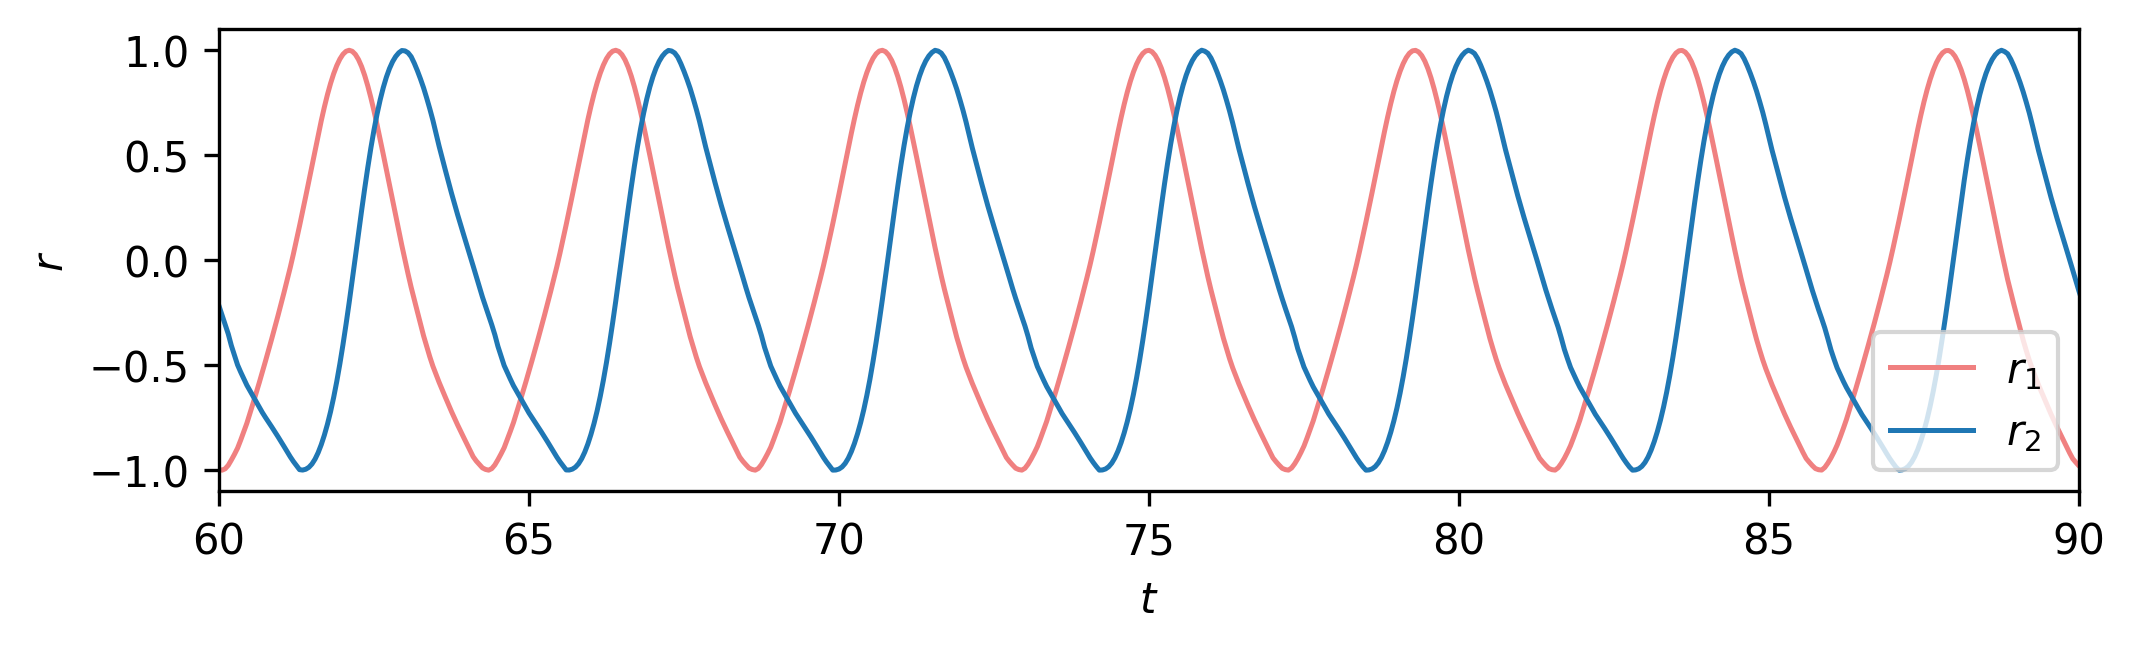

In [48]:
dt, t_0, t_end = 0.05, 0, 100
t_train = np.arange(t_0+dt, t_end-dt, dt)
t_train_span = (t_train[0], t_train[-1])

fig=plt.figure(dpi=300,figsize=(8,2))
plt.plot(t_train,x_train[0:1999,0],label=r'$r_1$',lw=1.2,color='lightcoral')
plt.plot(t_train,x_train[0:1999,1],label=r'$r_2$',lw=1.2)
plt.xlim([60,90])
plt.legend(loc='lower right')#,fontsize=12)
plt.xlabel(r'$t$')#,fontsize=20)
plt.ylabel(r'$r$')#,fontsize=20)
# plt.title('1 cylinder latent vector by SAE+POD')
#plt.axvline(x=60,c="k",ls="--",lw=1)
#plt.axvline(x=90,c="k",ls="--",lw=1)
plt.savefig(fname='1.png', dpi=300)
plt.show()

In [49]:
x0_train=x_train[0,:]
print(x0_train.shape)
print(x0_train.max(), x0_train.min())

(2,)
-0.3973136842250824 -0.9559053182601929


In [50]:
# Calculate time derivatives (dx/dt)
dxdt = np.array([np.gradient(x_train[:, i], dt) for i in range(x_train.shape[1])]).T
print(dxdt.shape)

(1998, 2)


In [ ]:
degree_list = [6]   # Try multiple degrees
alpha_list = [6e-7]  # Try multiple alphas
#Without PCA Implementation: 
# 🚀 Outer loop: grid search
# 🚀 Initialize tracking:
best_derivative_error = np.inf
best_traj_error = np.inf
best_config = None


In [ ]:
delta=1.0
max_iter=20
lasso_tol=1e-3
for degree in degree_list:
    for alpha in alpha_list:

        print(f"\n=== Testing degree={degree}, alpha={alpha} ===")
        # 1️ Build Theta:
        matrix_theta = Theta(x_train, t_train, degree, True, False, False, False)

        # 2️ Fit Adaptive Lasso:
        coefficients = np.zeros((matrix_theta.shape[1], x_train.shape[1]))
        for i in range(x_train.shape[1]):
            print(f"\nFitting variable {i} (degree={degree}, alpha={alpha})")
            coefficients[:, i] = alasso(matrix_theta, dxdt[:, i], alpha, delta, max_iter, lasso_tol)

        # 3️ Compute derivative error (no integration yet!):
        xdot_sindy = matrix_theta @ coefficients

        derivative_error = np.linalg.norm(xdot_sindy - dxdt)
        relative_derivative_error = derivative_error / np.linalg.norm(dxdt)

        print(f"Derivative error = {derivative_error:.6e}")
        print(f"Relative derivative error = {relative_derivative_error:.6e}")

        dt = t_train[1] - t_train[0]
        x_manual = [x0_train]
        def f(x):
            theta_x = Theta(x.reshape(1, -1), np.array([0.0]), degree, True, False, False, False)
            return (theta_x @ coefficients).flatten()
        for t in t_train[:-1]:
            x_current = x_manual[-1]
            k1 = f(x_current)
            k2 = f(x_current + 0.5 * dt * k1)
            k3 = f(x_current + 0.5 * dt * k2)
            k4 = f(x_current + dt * k3)
            x_next = x_current + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)
            x_manual.append(x_next)
        x_latent_sindy = np.array(x_manual)

        # 5️ Compute trajectory error:
        if x_latent_sindy.shape[0] != x_train.shape[0]:
            print(f"⚠️ WARNING: shape mismatch — skipping trajectory error.")
            print(f"Until now Best Trajectory error = {best_traj_error:.6e}")
        else:
            traj_error = np.linalg.norm(x_latent_sindy - x_train)
            relative_traj_error = traj_error / np.linalg.norm(x_train)

            print(f"Trajectory error = {traj_error:.6e}")
            print(f"Relative trajectory error = {relative_traj_error:.6e}")
            print(f"Best Trajectory error = {best_traj_error:.6e}")
            print(x_train.max(), x_train.min())
            # 6️ Update best result:
            if relative_traj_error < best_traj_error:
                best_traj_error = relative_traj_error
                best_config = (degree, alpha)
                print(f"\n🚀 New BEST TRAJECTORY config found! degree={degree}, alpha={alpha}, relative_traj_error={relative_traj_error:.6e}")






=== Testing degree=6, alpha=6e-07 ===

Fitting variable 0 (degree=6, alpha=6e-07)

Iteration Weight Δ       Coef Δ         L1 Norm        Max Coef       Nonzero Coefs  
--------------------------------------------------------------------------------
0         4.082e+14      1.234e+00      2.767e+01      3.167e+00      47             
1         1.837e+15      4.082e+06      3.078e+01      4.729e+00      38             
2         1.020e+15      2.245e+07      3.248e+01      5.197e+00      33             
3         6.122e+14      3.265e+07      2.484e+01      4.035e+00      30             
4         2.041e+14      3.878e+07      2.754e+01      4.409e+00      29             
5         7.802e-01      4.082e+07      2.844e+01      4.676e+00      29             
6         2.041e+14      4.082e+07      2.938e+01      4.791e+00      28             
7         1.310e+02      4.286e+07      1.613e+01      2.111e+00      28             
8         2.041e+14      4.286e+07      2.075e+01      2.997e

In [ ]:
# Final report:
print("\n=== GRID SEARCH COMPLETE ===")
print(f" Best TRAJECTORY config: degree={best_config[0]}, alpha={best_config[1]}")
print(f"Best trajectory error: {best_traj_error:.6e}")
print(f"\n=== Testing degree={degree}, alpha={alpha} ===")


=== GRID SEARCH COMPLETE ===
✅ Best TRAJECTORY config: degree=6, alpha=6e-07
✅ Best trajectory error: 2.344678e-02

=== Testing degree=6, alpha=6e-07 ===


In [ ]:
if (len(degree_list)!=1):
    # 1️ Build Theta:
    matrix_theta = Theta(x_train, t_train, best_config[0], True, False, False, False)
    # 2️ Fit Adaptive Lasso:
    coefficients = np.zeros((matrix_theta.shape[1], x_train.shape[1]))
    for i in range(x_train.shape[1]):
         print(f"\nFitting variable {i} (degree={best_config[0]}, alpha={best_config[1]})")
         coefficients[:, i] = alasso(matrix_theta, dxdt[:, i], best_config[1], delta, max_iter, lasso_tol)
    # 3️ Compute derivative error (no integration yet!):
    xdot_sindy = matrix_theta @ coefficients
    derivative_error = np.linalg.norm(xdot_sindy - dxdt)
    relative_derivative_error = derivative_error / np.linalg.norm(dxdt)
    print(f"Derivative error = {derivative_error:.6e}")
    print(f"Relative derivative error = {relative_derivative_error:.6e}")

    dt = t_train[1] - t_train[0]
    x_manual = [x0_train]
    def f(x):
        theta_x = Theta(x.reshape(1, -1), np.array([0.0]), best_config[0], True, False, False, False)
        return (theta_x @ coefficients).flatten()
    for t in t_train[:-1]:
        x_current = x_manual[-1]
        k1 = f(x_current)
        k2 = f(x_current + 0.5 * dt * k1)
        k3 = f(x_current + 0.5 * dt * k2)
        k4 = f(x_current + dt * k3)
        x_next = x_current + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)
        x_manual.append(x_next)
    x_latent_sindy = np.array(x_manual)

    # Compute trajectory error:
    if x_latent_sindy.shape[0] != x_train.shape[0]:
        print(f" WARNING: shape mismatch — skipping trajectory error.")
    else:
        traj_error = np.linalg.norm(x_latent_sindy - x_train)
        relative_traj_error = traj_error / np.linalg.norm(x_train)
        print(f"Trajectory error = {traj_error:.6e}")
        print(f"Relative trajectory error = {relative_traj_error:.6e}")


In [63]:
re_r1=x_latent_sindy
for i in range(len(re_r1)):
  re_r1[i,:] = (re_r1[i,:]*(r_max12-r_min12)+r_max12+r_min12)/2
re_r2= sae_pca.inverse_transform(re_r1)
for i in range(len(re_r1)):
  re_r1[i,:] = (re_r2[i,:]*(r_max11-r_min11)+r_max11+r_min11)/2

In [61]:
n_ts, N, k = 2000, 8192*2, 2
X = np.zeros((n_ts,N))
X[:,:] = np.hstack([Un,Vn])#Un[-n_ts:,:]
X_avg = np.mean(X,axis=0)
Xrall = np.zeros((n_ts,N))
for i in range(0,n_ts):
  Xrall[i,:] = X[i,:]-X_avg
Xrall_sae = cp(Xrall)
X0_sae = cp(Xrall_sae)
min = np.min(X0_sae,axis=0)
max = np.max(X0_sae,axis=0)
X0_sae = X0_sae-min
X0_sae=X0_sae.reshape((X0_sae.shape[0],-1))

In [64]:
decoded_data = decoder_sae.predict(re_r1)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [65]:
Ux_reconstructed = np.zeros_like(decoded_data)
Ux_reconstructed = decoded_data+ X_avg + min 
Ux_reconstructed=Ux_reconstructed.reshape(n_ts-2,N)
Ux_data=cp(X)
Ux_true = Ux_data[1:2000-1,:].reshape(1998,-1) 
full_space_error = np.linalg.norm(Ux_reconstructed - Ux_true)
relative_full_space_error = 1-full_space_error / np.linalg.norm(Ux_true)
print(full_space_error)
print(relative_full_space_error)

58.3821473769686
0.9864698697093621


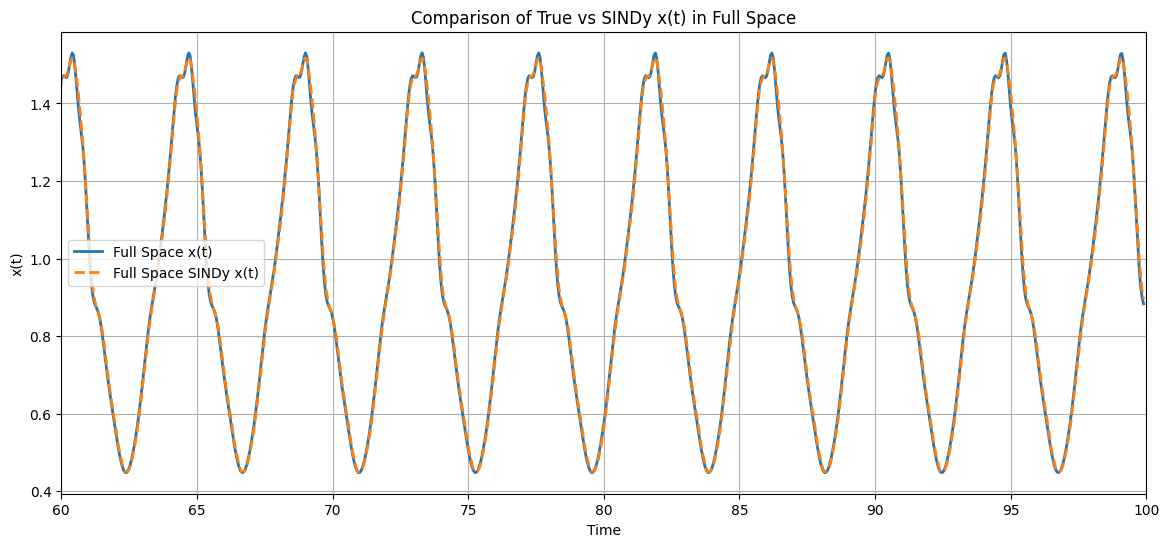

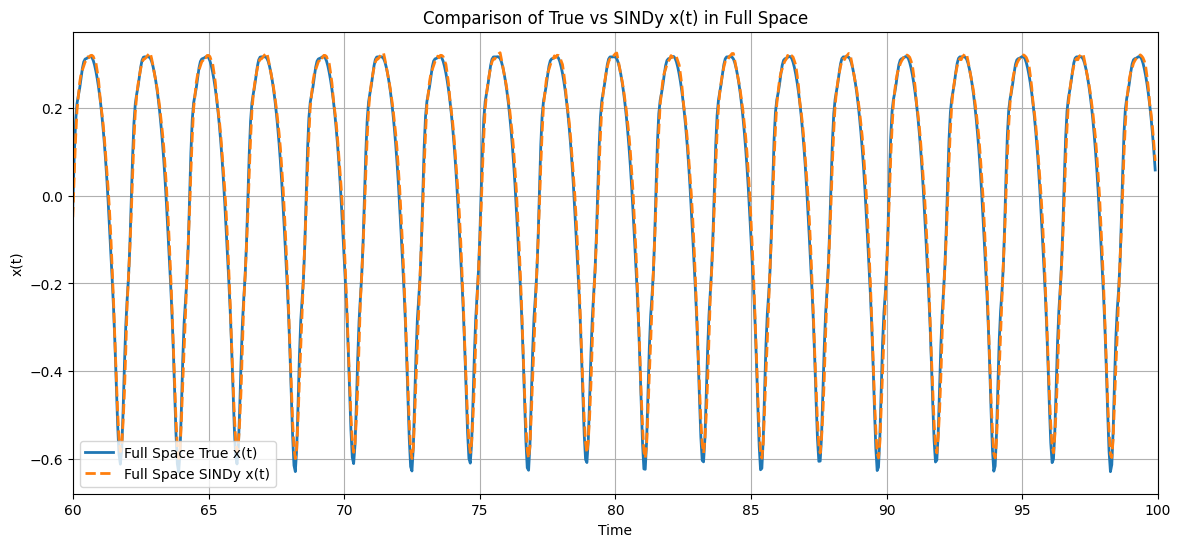

(1998, 2) (1998, 2) (1998,)


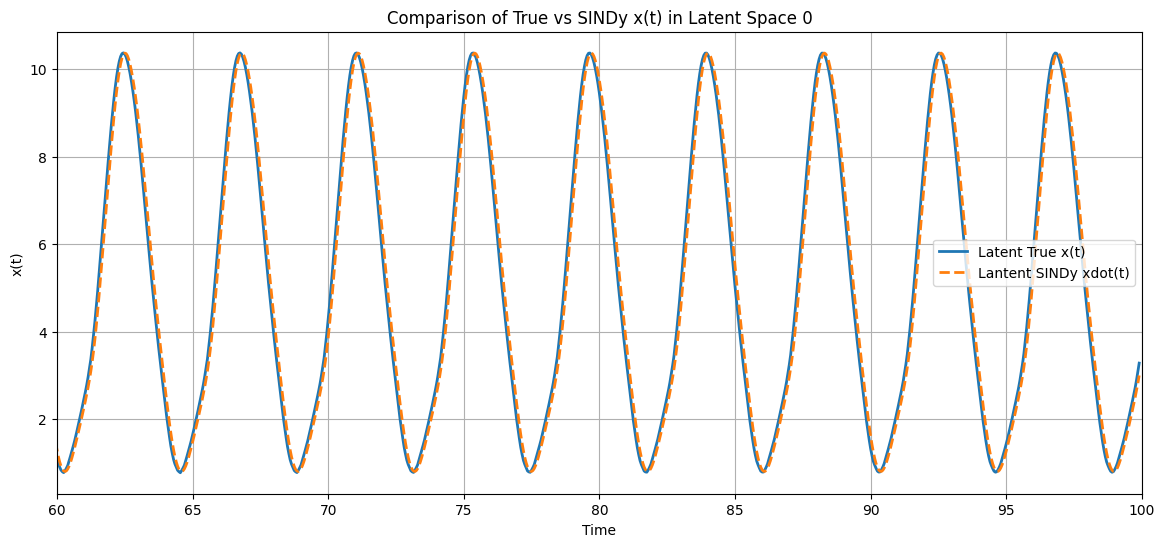

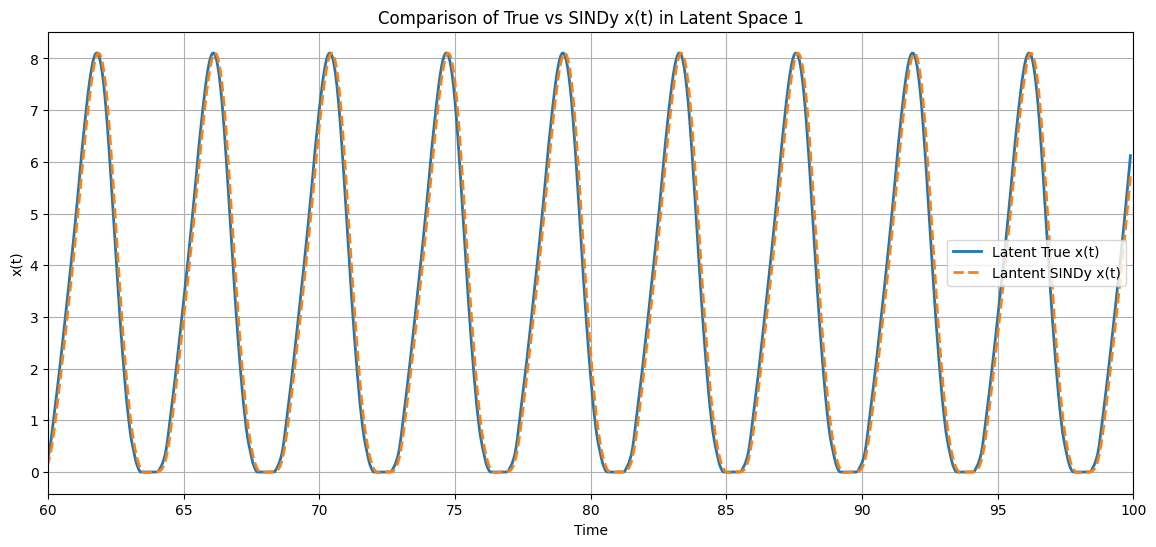

In [66]:
plt.figure(figsize=(14, 6))
plt.plot(t_train, Ux_true[:, 5486], label='Full Space x(t)', linewidth=2)
plt.plot(t_train, Ux_reconstructed[:, 5486], '--', label='Full Space SINDy x(t)', linewidth=2)
plt.xlabel('Time')
plt.xlim(60,100)
plt.ylabel(f'x(t)')
plt.title(f'Comparison of True vs SINDy x(t) in Full Space')
plt.legend()
plt.grid(True)
plt.savefig(fname='Comparison of True vs SINDy x(t) in Full Space-SAE+POD 1', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(14, 6))
plt.plot(t_train, Ux_true[:, 2272], label='Full Space True x(t)', linewidth=2)
plt.plot(t_train, Ux_reconstructed[:, 2272], '--', label='Full Space SINDy x(t)', linewidth=2)
plt.xlabel('Time')
plt.xlim(60,100)
plt.ylabel(f'x(t)')
plt.title(f'Comparison of True vs SINDy x(t) in Full Space')
plt.legend()
plt.grid(True)
plt.savefig(fname='Comparison of True vs SINDy x(t) in Full Space-SAE+POD 2', dpi=300, bbox_inches='tight')
plt.show()

x_train = np.load('modelres/u_sae_enc_paper'+n+'.npy')[-1998:,:]
#x_train=scaler.fit_transform(x_train)
print(x_train.shape, x_latent_sindy.shape, t_train.shape)
plt.figure(figsize=(14, 6))
plt.plot(t_train, x_train[:, 0], label='Latent True x(t)', linewidth=2)
plt.plot(t_train, x_latent_sindy[:, 0], '--', label='Lantent SINDy xdot(t)', linewidth=2)
plt.xlabel('Time')
plt.xlim(60,100)
plt.ylabel(f'x(t)')
plt.title(f'Comparison of True vs SINDy x(t) in Latent Space 0')
plt.legend()
plt.grid(True)
plt.savefig(fname='Comparison of True vs SINDy x(t) in Latent Space 0', dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(14, 6))
plt.plot(t_train, x_train[:, 1], label='Latent True x(t)', linewidth=2)
plt.plot(t_train, x_latent_sindy[:, 1], '--', label='Lantent SINDy x(t)', linewidth=2)
plt.xlabel('Time')
plt.xlim(60,100)
plt.ylabel(f'x(t)')
plt.title(f'Comparison of True vs SINDy x(t) in Latent Space 1')
plt.legend()
plt.grid(True)
plt.savefig(fname='Comparison of True vs SINDy x(t) in Latent Space 1', dpi=300, bbox_inches='tight')
plt.show()


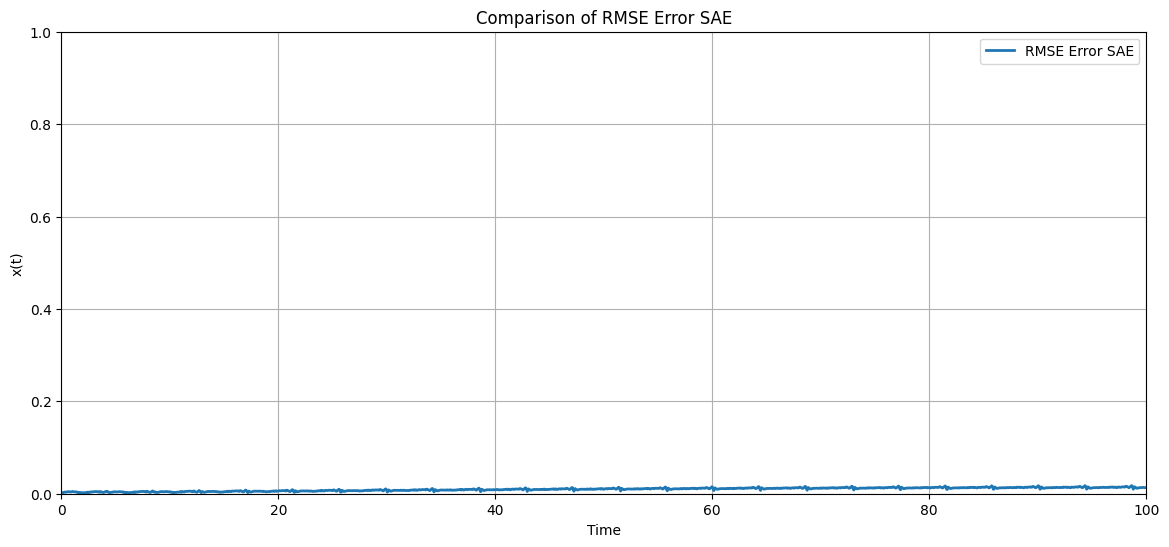

In [67]:
rmse_sae = np.zeros((len(Ux_true),))
rmse_sae_pod = np.zeros((len(Ux_true),))
for i in range(len(Ux_true)):
  rmse_sae[i] = np.sqrt(((Ux_true[i,:]-Ux_reconstructed[i,:]) ** 2).mean())

plt.figure(figsize=(14, 6))
plt.plot(t_train,rmse_sae, label='RMSE Error SAE', linewidth=2)
plt.xlabel('Time')
plt.xlim(0,100)
plt.ylim(0,1)
plt.ylabel(f'x(t)')
plt.title(f'Comparison of RMSE Error SAE')
plt.legend()
plt.grid(True)
plt.savefig(fname='Comparison of RMSE Error SAE+POD', dpi=300, bbox_inches='tight')
plt.show()
